In [1]:
import os
from pathlib import Path

from itertools import chain, product

import math
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import time
from datetime import datetime, timedelta
import pymmwr

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

# https://github.com/reichlab/timeseriesutils
from timeseriesutils import featurize

In [2]:
os.chdir('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting')

In [3]:
import sys
sys.path.append('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting/GBM/code')
import loader 


In [19]:
dat = pd.read_csv('NYC_ED/data/NYC_ED_cleaned_daily_weekly.csv')
dat

,Unnamed: 0,Borough,age_group,WeekStart,Week,Year,inc,population
0,1,Bronx,Ages 0-4 years,2015-12-27,52,2015,98,1472654.0
1,2,Bronx,Ages 0-4 years,2016-01-03,1,2016,232,1472654.0
2,3,Bronx,Ages 0-4 years,2016-01-10,2,2016,184,1472654.0
3,4,Bronx,Ages 0-4 years,2016-01-17,3,2016,140,1472654.0
4,5,Bronx,Ages 0-4 years,2016-01-24,4,2016,169,1472654.0
...,...,...,...,...,...,...,...,...
16375,16376,Unknown,All age groups,2024-11-10,45,2024,85,NaN
16376,16377,Unknown,All age groups,2024-11-17,46,2024,84,NaN
16377,16378,Unknown,All age groups,2024-11-24,47,2024,99,NaN
16378,16379,Unknown,All age groups,2024-12-01,48,2024,126,NaN


In [20]:
dat= dat[dat["age_group"] == "All age groups"]
dat = dat[dat["Borough"] != 'Unknown']
dat

,Unnamed: 0,Borough,age_group,WeekStart,Week,Year,inc,population
1872,1873,Bronx,All age groups,2015-12-27,52,2015,165,1472654.0
1873,1874,Bronx,All age groups,2016-01-03,1,2016,447,1472654.0
1874,1875,Bronx,All age groups,2016-01-10,2,2016,387,1472654.0
1875,1876,Bronx,All age groups,2016-01-17,3,2016,350,1472654.0
1876,1877,Bronx,All age groups,2016-01-24,4,2016,429,1472654.0
...,...,...,...,...,...,...,...,...
14035,14036,Staten Island,All age groups,2024-11-10,45,2024,57,495747.0
14036,14037,Staten Island,All age groups,2024-11-17,46,2024,73,495747.0
14037,14038,Staten Island,All age groups,2024-11-24,47,2024,66,495747.0
14038,14039,Staten Island,All age groups,2024-12-01,48,2024,89,495747.0


In [21]:

dat['inc2'] = dat['inc']/(dat['population']/ 100000)
dat['collection_week'] = pd.to_datetime(dat['WeekStart'])
dat = dat[dat['population'].notna()]
dat.rename(columns={'population': 'pop'}, inplace=True)
dat.rename(columns={'Borough': 'resident_location'}, inplace=True)
dat = dat[['collection_week', 'resident_location', 'inc2', 'pop']]
dat

,collection_week,resident_location,inc2,pop
1872,2015-12-27,Bronx,11.204261,1472654.0
1873,2016-01-03,Bronx,30.353362,1472654.0
1874,2016-01-10,Bronx,26.279085,1472654.0
1875,2016-01-17,Bronx,23.766615,1472654.0
1876,2016-01-24,Bronx,29.131079,1472654.0
...,...,...,...,...
14035,2024-11-10,Staten Island,11.497800,495747.0
14036,2024-11-17,Staten Island,14.725253,495747.0
14037,2024-11-24,Staten Island,13.313242,495747.0
14038,2024-12-01,Staten Island,17.952706,495747.0


In [22]:
# Create epiweek and year columns
dat_arrange = dat.assign(
    epiweek=dat['collection_week'].dt.isocalendar().week,
    year=dat['collection_week'].dt.year
)


dat_arrange = dat_arrange.assign(
    season=lambda x: x['year'].astype(str) + "/" + (x['year'] + 1).astype(str).str[-2:])
dat_arrange['season_week'] = loader.convert_epiweek_to_season_week(dat_arrange['year'].to_numpy(), dat_arrange['epiweek'].to_numpy())
dat_arrange


,collection_week,resident_location,inc2,pop,epiweek,year,season,season_week
1872,2015-12-27,Bronx,11.204261,1472654.0,52,2015,2015/16,22
1873,2016-01-03,Bronx,30.353362,1472654.0,53,2016,2016/17,23
1874,2016-01-10,Bronx,26.279085,1472654.0,1,2016,2016/17,24
1875,2016-01-17,Bronx,23.766615,1472654.0,2,2016,2016/17,25
1876,2016-01-24,Bronx,29.131079,1472654.0,3,2016,2016/17,26
...,...,...,...,...,...,...,...,...
14035,2024-11-10,Staten Island,11.497800,495747.0,45,2024,2024/25,15
14036,2024-11-17,Staten Island,14.725253,495747.0,46,2024,2024/25,16
14037,2024-11-24,Staten Island,13.313242,495747.0,47,2024,2024/25,17
14038,2024-12-01,Staten Island,17.952706,495747.0,48,2024,2024/25,18


In [23]:
df = dat_arrange
df.rename(columns={'inc2': 'inc'}, inplace=True)
df.rename(columns={'resident_location': 'location'}, inplace=True)
df

,collection_week,location,inc,pop,epiweek,year,season,season_week
1872,2015-12-27,Bronx,11.204261,1472654.0,52,2015,2015/16,22
1873,2016-01-03,Bronx,30.353362,1472654.0,53,2016,2016/17,23
1874,2016-01-10,Bronx,26.279085,1472654.0,1,2016,2016/17,24
1875,2016-01-17,Bronx,23.766615,1472654.0,2,2016,2016/17,25
1876,2016-01-24,Bronx,29.131079,1472654.0,3,2016,2016/17,26
...,...,...,...,...,...,...,...,...
14035,2024-11-10,Staten Island,11.497800,495747.0,45,2024,2024/25,15
14036,2024-11-17,Staten Island,14.725253,495747.0,46,2024,2024/25,16
14037,2024-11-24,Staten Island,13.313242,495747.0,47,2024,2024/25,17
14038,2024-12-01,Staten Island,17.952706,495747.0,48,2024,2024/25,18


In [24]:
df['log_pop'] = np.log(df['pop'])
df['inc_4rt'] = (df['inc'] + 0.01)**0.25
df['inc_4rt_scale_factor'] = df \
.assign(inc_4rt_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt'])) \
.groupby(['location'])['inc_4rt_in_season'] \
.transform(lambda x: x.quantile(0.95))

df['inc_4rt_cs'] = df['inc_4rt'] / (df['inc_4rt_scale_factor'] + 0.01)
df['inc_4rt_center_factor'] = df \
.assign(inc_4rt_cs_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt_cs'])) \
.groupby(['location'])['inc_4rt_cs_in_season'] \
.transform(lambda x: x.mean())
df['inc_4rt_cs'] = df['inc_4rt_cs'] - df['inc_4rt_center_factor']
df
  

,collection_week,location,inc,pop,epiweek,year,season,season_week,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
1872,2015-12-27,Bronx,11.204261,1472654.0,52,2015,2015/16,22,14.202577,1.829965,3.187628,-0.177970,0.750258
1873,2016-01-03,Bronx,30.353362,1472654.0,53,2016,2016/17,23,14.202577,2.347402,3.187628,-0.016151,0.750258
1874,2016-01-10,Bronx,26.279085,1472654.0,1,2016,2016/17,24,14.202577,2.264352,3.187628,-0.042123,0.750258
1875,2016-01-17,Bronx,23.766615,1472654.0,2,2016,2016/17,25,14.202577,2.208195,3.187628,-0.059685,0.750258
1876,2016-01-24,Bronx,29.131079,1472654.0,3,2016,2016/17,26,14.202577,2.323413,3.187628,-0.023653,0.750258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14035,2024-11-10,Staten Island,11.497800,495747.0,45,2024,2024/25,15,13.113821,1.841824,2.492528,0.002879,0.733106
14036,2024-11-17,Staten Island,14.725253,495747.0,46,2024,2024/25,16,13.113821,1.959248,2.492528,0.049801,0.733106
14037,2024-11-24,Staten Island,13.313242,495747.0,47,2024,2024/25,17,13.113821,1.910524,2.492528,0.030331,0.733106
14038,2024-12-01,Staten Island,17.952706,495747.0,48,2024,2024/25,18,13.113821,2.058699,2.492528,0.089542,0.733106


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_25990/3611234292.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=nhsn_to_plot,


<Axes: xlabel='season_week', ylabel='inc_4rt_cs'>

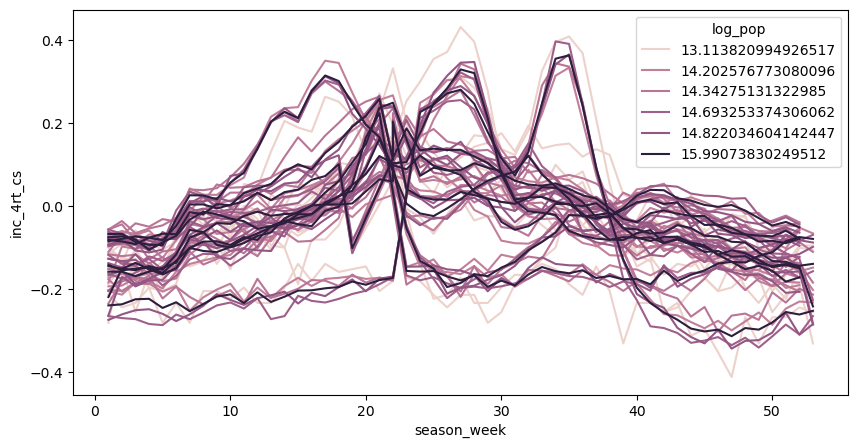

In [25]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)

nhsn_to_plot = df.assign(season_loc = lambda x: x['season'] + '_' + x['location'])
sns.lineplot(data=nhsn_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax)

In [26]:
# we already have incidence (transformed scale), season week and log population
feat_names = ['inc_4rt_cs', 'season_week', 'log_pop']

# one-hot encodings of data source, agg_level, and location
for c in ['location']:
    ohe = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df, ohe], axis=1)
    feat_names = feat_names + list(ohe.columns)

# season week relative to christmas
df = df.merge(
    loader.get_holidays() \
      .query("holiday == 'Christmas Day'") \
      .drop(columns=['holiday', 'date']) \
      .rename(columns={'season_week': 'xmas_week'}),
    how='left',
    on='season') \
  .assign(delta_xmas = lambda x: x['season_week'] - x['xmas_week'])

feat_names = feat_names + ['delta_xmas']

In [11]:
df

,collection_week,location,inc,pop,epiweek,year,season,season_week,log_pop,inc_4rt,...,location_Lubbock,location_McLennan,location_Montgomery,location_Nueces,location_Smith,location_Travis,location_Webb,location_Williamson,xmas_week,delta_xmas
0,2015-06-28,Nueces,0.283143,353178,26,2015,2015/16,49,12.774727,0.735817,...,0,0,0,1,0,0,0,0,21.0,28.0
1,2015-08-16,Hays,0.414822,241067,33,2015,2015/16,3,12.392830,0.807331,...,0,0,0,0,0,0,0,0,21.0,-18.0
2,2015-08-30,Hays,0.414822,241067,35,2015,2015/16,5,12.392830,0.807331,...,0,0,0,0,0,0,0,0,21.0,-16.0
3,2015-08-30,Nueces,0.283143,353178,35,2015,2015/16,5,12.774727,0.735817,...,0,0,0,1,0,0,0,0,21.0,-16.0
4,2015-09-20,Bell,0.269798,370647,38,2015,2015/16,8,12.823005,0.727296,...,0,0,0,0,0,0,0,0,21.0,-13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4549,2024-12-01,Nueces,24.350328,353178,48,2024,2024/25,18,12.774727,2.221625,...,0,0,0,1,0,0,0,0,NaN,NaN
4550,2024-12-01,Smith,14.134033,233479,48,2024,2024/25,18,12.360847,1.939293,...,0,0,0,0,1,0,0,0,NaN,NaN
4551,2024-12-01,Travis,2.480259,1290188,48,2024,2024/25,18,14.070299,1.256207,...,0,0,0,0,0,1,0,0,NaN,NaN
4552,2024-12-01,Webb,28.826643,267114,48,2024,2024/25,18,12.495431,2.317321,...,0,0,0,0,0,0,1,0,NaN,NaN


In [27]:
feat_names

['inc_4rt_cs',
 'season_week',
 'log_pop',
 'location_Bronx',
 'location_Brooklyn',
 'location_Citywide',
 'location_Manhattan',
 'location_Queens',
 'location_Staten Island',
 'delta_xmas']

In [28]:
df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': [4, 6],
                'fill_edges': False
            }
        },
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': [3, 5],
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'inc_4rt_cs',
                'group_columns': ['location'],
                'window_size': [2, 4]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'lag',
            'args': {
                'columns': ['inc_4rt_cs'] + new_feat_names,
                'lags': [1, 2]
            }
        }
    ])
feat_names = feat_names + new_feat_names

print(df)
print(feat_names)

     collection_week       location        inc        pop  epiweek  year  \
0         2015-12-27          Bronx  11.204261  1472654.0       52  2015   
1         2016-01-03          Bronx  30.353362  1472654.0       53  2016   
2         2016-01-10          Bronx  26.279085  1472654.0        1  2016   
3         2016-01-17          Bronx  23.766615  1472654.0        2  2016   
4         2016-01-24          Bronx  29.131079  1472654.0        3  2016   
...              ...            ...        ...        ...      ...   ...   
2803      2024-11-10  Staten Island  11.497800   495747.0       45  2024   
2804      2024-11-17  Staten Island  14.725253   495747.0       46  2024   
2805      2024-11-24  Staten Island  13.313242   495747.0       47  2024   
2806      2024-12-01  Staten Island  17.952706   495747.0       48  2024   
2807      2024-12-08  Staten Island   5.849758   495747.0       49  2024   

       season season_week    log_pop   inc_4rt  ...  \
0     2015/16          22  14.20

/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(taylor_coefs_one_column_grp,
/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this w

In [29]:
df.shape

(2808, 59)

In [30]:
new_feat_names

['inc_4rt_cs_lag1',
 'inc_4rt_cs_lag2',
 'inc_4rt_cs_taylor_d2_c0_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c0_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c1_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c1_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c2_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c2_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c0_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c0_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c1_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c1_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c2_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c2_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c0_w3t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c0_w3t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2',
 'inc_4rt_cs_rollmean_w2_lag1',
 'inc_4rt_cs_rollmean_w2_lag2',
 'inc_4rt_cs_rollmean_w4_lag1',
 'in

In [31]:
max_horizon = 4

# bagging setup
num_bags = 100
bag_frac_samples = 1 # 0.7

In [32]:
# import importlib
# featurize = importlib.reload(featurize)

# last date with observed data
# last_obs_date = pd.to_datetime(df.groupby(['location', 'pathogen_covid'])['date'].max().min())
# print(f'last_obs_date: {last_obs_date}')

# how far out to forecast to get to 28 days after due date
# due_date = forecast_date
# extra_horizons_rel_obs = (due_date - last_obs_date.date()).days
# effective_horizon_rel_obs = max_horizon + extra_horizons_rel_obs

# add forecast targets
df_with_pred_targets, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'horizon_targets',
            'args': {
                'columns': 'inc_4rt_cs',
                'horizons': [(i+1) for i in range(max_horizon)]
            }
        }
    ])
feat_names = feat_names + new_feat_names

# we will model the differences between the prediction target and the most
# recent observed value
df_with_pred_targets['delta_target'] = df_with_pred_targets['inc_4rt_cs_target'] - df_with_pred_targets['inc_4rt_cs']

print(new_feat_names)
print(df_with_pred_targets)

['horizon']
     collection_week       location        inc        pop  epiweek  year  \
0         2015-12-27          Bronx  11.204261  1472654.0       52  2015   
1         2016-01-03          Bronx  30.353362  1472654.0       53  2016   
2         2016-01-10          Bronx  26.279085  1472654.0        1  2016   
3         2016-01-17          Bronx  23.766615  1472654.0        2  2016   
4         2016-01-24          Bronx  29.131079  1472654.0        3  2016   
...              ...            ...        ...        ...      ...   ...   
2803      2024-11-10  Staten Island  11.497800   495747.0       45  2024   
2804      2024-11-17  Staten Island  14.725253   495747.0       46  2024   
2805      2024-11-24  Staten Island  13.313242   495747.0       47  2024   
2806      2024-12-01  Staten Island  17.952706   495747.0       48  2024   
2807      2024-12-08  Staten Island   5.849758   495747.0       49  2024   

       season season_week    log_pop   inc_4rt  ...  \
0     2015/16       

In [33]:
df_with_pred_targets.shape

(11232, 62)

In [34]:
df_with_pred_targets[df_with_pred_targets['inc_4rt_cs_target'].isna()]


,collection_week,location,inc,pop,epiweek,year,season,season_week,log_pop,inc_4rt,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
467,2024-12-08,Bronx,17.179867,1472654.0,49,2024,2024/25,19,14.202577,2.036189,...,0.067110,0.016754,0.016241,0.082229,0.056538,0.062911,0.045205,NaN,1,NaN
935,2024-12-08,Brooklyn,11.987980,2736074.0,49,2024,2024/25,19,14.822035,1.861131,...,0.106362,0.018853,0.018628,0.115236,0.100281,0.094651,0.077639,NaN,1,NaN
1403,2024-12-08,Citywide,12.698499,8804190.0,49,2024,2024/25,19,15.990738,1.888094,...,0.072804,0.016707,0.014551,0.085636,0.066847,0.068059,0.051266,NaN,1,NaN
1871,2024-12-08,Manhattan,10.033932,1694251.0,49,2024,2024/25,19,14.342751,1.780229,...,0.068521,0.006034,0.008112,0.063825,0.069035,0.065160,0.058252,NaN,1,NaN
2339,2024-12-08,Queens,12.430034,2405464.0,49,2024,2024/25,19,14.693253,1.878042,...,0.053381,0.017378,0.010831,0.075335,0.048958,0.053843,0.036272,NaN,1,NaN
2807,2024-12-08,Staten Island,5.849758,495747.0,49,2024,2024/25,19,13.113821,1.555858,...,0.047335,0.027753,0.023236,0.059936,0.040066,0.043138,0.011879,NaN,1,NaN
466,2024-12-01,Bronx,54.799023,1472654.0,48,2024,2024/25,18,14.202577,2.720903,...,0.045279,0.016241,0.008998,0.056538,0.043593,0.045205,0.027334,NaN,2,NaN
467,2024-12-08,Bronx,17.179867,1472654.0,49,2024,2024/25,19,14.202577,2.036189,...,0.067110,0.016754,0.016241,0.082229,0.056538,0.062911,0.045205,NaN,2,NaN
934,2024-12-01,Brooklyn,34.611637,2736074.0,48,2024,2024/25,18,14.822035,2.425699,...,0.080540,0.018628,0.012776,0.100281,0.074065,0.077639,0.059122,NaN,2,NaN
935,2024-12-08,Brooklyn,11.987980,2736074.0,49,2024,2024/25,19,14.822035,1.861131,...,0.106362,0.018853,0.018628,0.115236,0.100281,0.094651,0.077639,NaN,2,NaN


In [35]:
df_with_pred_targets2 = df_with_pred_targets.query("season_week >= 5 and season_week <= 45")

In [36]:
df_with_pred_targets2.shape

(8760, 62)

In [22]:
#date_list <- c("2023-10-01", "2023-11-05", "2023-12-10", "2024-01-14", "2024-02-18", "2024-03-24")

In [38]:
start_date = datetime(2023, 12, 10)
end_date = start_date + timedelta(days=1) 
#end_date = datetime(2024, 3, 30)


#start_date = datetime(2024, 10, 6)
#end_date = datetime(2024, 12, 1)

current_date = start_date
while current_date <= end_date:
    print(current_date.strftime('%Y-%m-%d'))  # Print or use the date as needed
    forecast_date = pd.to_datetime(current_date)

    # Filter the DataFrame based on the comparison
    df_with_pred_targets = df_with_pred_targets2[df_with_pred_targets2['collection_week'] <= forecast_date]
    df_with_pred_targets.shape
    
    # "test set" df used to generate look-ahead predictions
    df_test = df_with_pred_targets \
        .loc[df_with_pred_targets.collection_week == df_with_pred_targets.collection_week.max()] \
        .copy()
    x_test = df_test[feat_names]

    # "train set" df for model fitting; target value non-missing
    df_train = df_with_pred_targets.loc[~df_with_pred_targets['delta_target'].isna().values]
    x_train = df_train[feat_names]
    y_train = df_train['delta_target']

    # quantile levels at which to generate predictions
    q_levels = [0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35,
                0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80,
                0.85, 0.90, 0.95, 0.975, 0.99]
    q_labels = ['0.01', '0.025', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35',
                '0.4', '0.45', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8',
                '0.85', '0.9', '0.95', '0.975', '0.99']

    # seed for random number generation, based on reference date
    rng_seed = int(time.mktime(forecast_date.timetuple()))
    rng = np.random.default_rng(seed=rng_seed)
    # seeds for lgb model fits, one per combination of bag and quantile level
    lgb_seeds = rng.integers(1e8, size=(num_bags, len(q_levels)))

    # training loop over bags
    # for q_level, q_label in zip(q_levels, q_labels):
        # print(q_label)

    oob_preds_by_bag = np.empty((x_train.shape[0], num_bags, len(q_levels)))
    oob_preds_by_bag[:] = np.nan
    test_preds_by_bag = np.empty((x_test.shape[0], num_bags, len(q_levels)))

    train_seasons = df_train['season'].unique()

    # Convert season_week and delta_xmas to numeric
    x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
    x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')

    x_test['season_week'] = pd.to_numeric(x_test['season_week'], errors='coerce')
    x_test['delta_xmas'] = pd.to_numeric(x_test['delta_xmas'], errors='coerce')

    #print(x_train.dtypes[x_train.dtypes == 'object'])
    #print(x_test.dtypes[x_test.dtypes == 'object'])

    for b in range(num_bags):
        print(f'bag number {b+1}')
        # get indices of observations that are in bag
        bag_seasons = rng.choice(
            train_seasons,
            size = int(len(train_seasons) * bag_frac_samples),
            replace=False)
        bag_obs_inds = df_train['season'].isin(bag_seasons)
        
        for q_ind, q_level in enumerate(q_levels):
            # fit to bag
            model = lgb.LGBMRegressor(verbosity=-1,
                                        # hist_pool_size=1000,
                                        # objective='mean_absolute_error')
                                        objective='quantile',
                                        alpha = q_level,
                                        random_state=lgb_seeds[b, q_ind])
            model.fit(X=x_train.loc[bag_obs_inds, :], y=y_train.loc[bag_obs_inds])
            
            # oob predictions and test set predictions
            #oob_preds_by_bag[~bag_obs_inds, b, q_ind] = model.predict(X=x_train.loc[~bag_obs_inds, :])
            test_preds_by_bag[:, b, q_ind] = model.predict(X=x_test)

    # df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)
    # df_test['delta_hat_stage1'] = np.median(test_preds_by_bag, axis=1)

    #oob_pred_qs = np.nanmedian(oob_preds_by_bag, axis=1)
    test_pred_qs = np.median(test_preds_by_bag, axis=1)
    test_pred_qs_sorted = np.sort(test_pred_qs, axis=1)  # Sort to enforce monotonicity
    test_pred_qs_sorted.shape

    test_pred_qs_df = pd.DataFrame(test_pred_qs_sorted)
    test_pred_qs_df.columns = q_labels
    test_pred_qs_df

    df_test.reset_index(drop=True, inplace=True)
    df_test_w_preds = pd.concat([df_test, test_pred_qs_df], axis=1)

    # delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
    cols_to_keep = ['location', 'collection_week', 'pop',
                    'inc_4rt_cs', 'horizon',
                    'inc_4rt_center_factor', 'inc_4rt_scale_factor']
    preds_df = df_test_w_preds[cols_to_keep + q_labels]
    preds_df = pd.melt(preds_df,
                    id_vars=cols_to_keep,
                    var_name='quantile',
                    value_name = 'delta_hat')

    # build data frame with predictions on the original scale
    preds_df['inc_4rt_cs_target_hat'] = preds_df['inc_4rt_cs'] + preds_df['delta_hat']
    preds_df['inc_4rt_target_hat'] = (preds_df['inc_4rt_cs_target_hat'] + preds_df['inc_4rt_center_factor']) * (preds_df['inc_4rt_scale_factor'] + 0.01)
    preds_df['value'] = (np.maximum(preds_df['inc_4rt_target_hat'], 0.0) ** 4 - 0.01 - 0.75**4) * preds_df['pop'] / 100000
    preds_df['value'] = np.maximum(preds_df['value'], 0.0)

    # keep just required columns and rename to match hub format
    preds_df = preds_df[['location', 'collection_week', 'horizon', 'quantile', 'value']] \
        .rename(
            columns={
                'quantile': 'output_type_id'
            })

    preds_df['target_end_date'] = preds_df['collection_week'] + pd.to_timedelta(7*preds_df['horizon'], unit='days')
    preds_df['target'] = 'wk inc flu ED'

    preds_df['output_type'] = 'quantile'

    if not Path('GBM/model_output/NYC_ED').exists():
        Path('GBM/model_output/NYC_ED').mkdir(parents=True)

    preds_df.to_csv(f'GBM/model_output/NYC_ED/{str(forecast_date.date())}-GBM.csv', index=False)
    current_date += timedelta(weeks=1)

2023-11-05
bag number 1


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_25990/60761094.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_25990/60761094.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_25990/60761094.py:57: SettingWithCopyWarn

bag number 2
bag number 3
bag number 4
bag number 5
bag number 6
bag number 7
bag number 8
bag number 9
bag number 10
bag number 11
bag number 12
bag number 13
bag number 14
bag number 15
bag number 16
bag number 17
bag number 18
bag number 19
bag number 20
bag number 21
bag number 22
bag number 23
bag number 24
bag number 25
bag number 26
bag number 27
bag number 28
bag number 29
bag number 30
bag number 31
bag number 32
bag number 33
bag number 34
bag number 35
bag number 36
bag number 37
bag number 38
bag number 39
bag number 40
bag number 41
bag number 42
bag number 43
bag number 44
bag number 45
bag number 46
bag number 47
bag number 48
bag number 49
bag number 50
bag number 51
bag number 52
bag number 53
bag number 54
bag number 55
bag number 56
bag number 57
bag number 58
bag number 59
bag number 60
bag number 61
bag number 62
bag number 63
bag number 64
bag number 65
bag number 66
bag number 67
bag number 68
bag number 69
bag number 70
bag number 71
bag number 72
bag number 73
